In [1]:
import tensorflow as tf
import os
import time
import datetime
import matplotlib.pyplot as plt

PATH = 'D:\\Eeshaan\\SOC-Winter\\SOC-Winter\\Sketch_To_Color\\archive\\data'

Checking for GPU (I had neglected this step in my first run thinking the versions were compatible, but had recently updated tensorflow, and hence the GAN was training on my CPU 🙁)

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.0
Num GPUs Available:  1


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
print(physical_devices[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
n_epochs = 100
buffer_size = len(os.listdir(PATH+'\\train'))
batch_size = 28
width = 256
height = 256

## Loading the images

## Pre-processing
We will be defining three functions to do some pre-processing : 
1. **resize** : To resize the given images to the given height and width. The given dataset has the images of size 512 x 512, and reduction of size to half i.e 256 x 256 decreases the training time. But, we resize to 286 x 286 first (in case there is some different sized image in the dataset), and then crop it to 256 x 256
2. **random_crop** : Returns the cropped images in the size 256 x 256
3. **normalize** : Normalizes the images to [-1,1]

[Done already in a .py file]

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [8]:

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, height, width, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [9]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
    
trainset = tf.data.Dataset.list_files(PATH+'\\train\\*.png')
trainset = trainset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
trainset = trainset.shuffle(buffer_size).batch(batch_size)

In [10]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   height, width)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
  
testset = tf.data.Dataset.list_files(PATH+'\\val\\*.png')
testset = testset.map(load_image_test)
testset = testset.batch(batch_size)

In [11]:
trainset = tf.data.Dataset.list_files(PATH + '\\train\\*.png')
trainset = trainset.map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
trainset = trainset.shuffle(buffer_size).batch(batch_size)

In [12]:
testset = tf.data.Dataset.list_files(PATH + '\\val\\*.png')
testset = testset.map(load_image_test)
testset = testset.batch(batch_size)

## Model

The downsampling stack of layers has Convolutional layers which result in a decrease in the size of the input image. And once the decreased image goes through the upsampling stack of layers which has kind of “reverse” Convolutional layers, the size is restored back to 256x256 px. Hence, the output of the Generator Model is a 256x256 px image with 3 output channels.

In [13]:
output_channels = 3

In [14]:
def downsample(filters, size, shape, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                               kernel_initializer=initializer, use_bias=False)
    )
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [15]:
def upsample(filters, size, shape, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape, padding='same',
                                        kernel_initializer=initializer, use_bias=False)        
    )
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [16]:
def buildGenerator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    
    down_stack = [
        downsample(64, 4, (None, 256, 256, 3), apply_batchnorm=False),
        downsample(128, 4, (None, 128, 128, 64)),
        downsample(256, 4, (None, 64, 64, 128)),
        downsample(512, 4, (None, 32, 32, 256)),
        downsample(512, 4, (None, 16, 16, 512)), 
        downsample(512, 4, (None, 8, 8, 512)), 
        downsample(512, 4, (None, 4, 4, 512)),
        downsample(512, 4, (None, 2, 2, 512)),
    ]
        
    up_stack = [
        upsample(512, 4, (None, 1, 1, 512), apply_dropout=True), 
        upsample(512, 4, (None, 2, 2, 1024), apply_dropout=True), 
        upsample(512, 4, (None, 4, 4, 1024), apply_dropout=True), 
        upsample(512, 4, (None, 8, 8, 1024)), 
        upsample(256, 4, (None, 16, 16, 1024)), 
        upsample(128, 4, (None, 32, 32, 512)), 
        upsample(64, 4, (None, 64, 64, 256)), 
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
generator = buildGenerator()

In [18]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [19]:

def downs(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                             kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def buildDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downs(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downs(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downs(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  

In [20]:
discriminator = buildDiscriminator()

In [21]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## Loss

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Lambda = 100

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    L1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (Lambda * L1_loss)
    
    return total_gen_loss, gan_loss, L1_loss

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [25]:
generator_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_opt = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [26]:
checkpoint_dir = './checkpts'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_opt,
                                 discriminator_optimizer=discriminator_opt,
                                 generator=generator,
                                 discriminator=discriminator
                                )

In [27]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], target[0], prediction[0]]
    
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [28]:
log_dir = 'logs/'

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [29]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [30]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch :", epoch)
        
        for i, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            
            if((i+1)%100 == 0):
                print()
            train_step(input_image, target, epoch)    
        print()
        
        if (epoch+1)%5 == 0:
            checkpoint.save(file_prefix= checkpoint_prefix)
            
        print('Time taken for epoch {} is {} sec\n'.format(epoch+1, time.time() - start))
        
    checkpoint.save(file_prefix = checkpoint_prefix)
        

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [32]:
#fit(trainset, n_epochs, testset)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

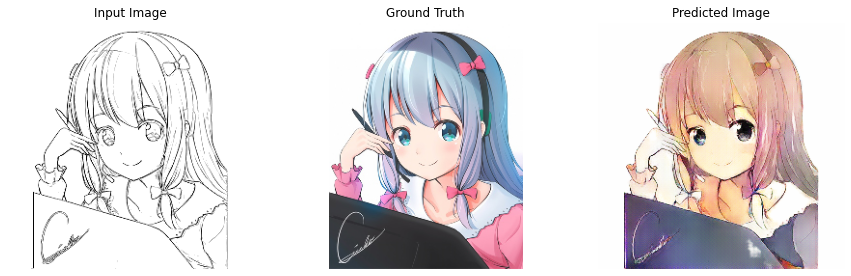

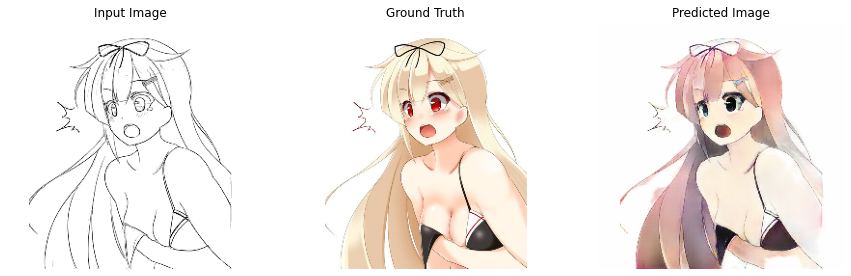

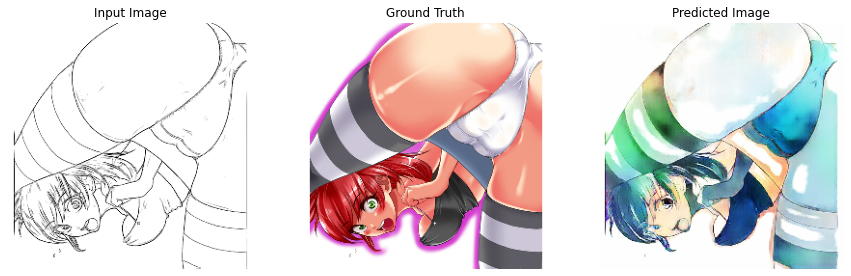

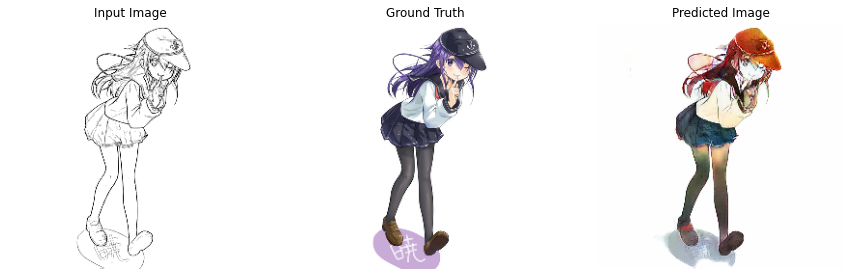

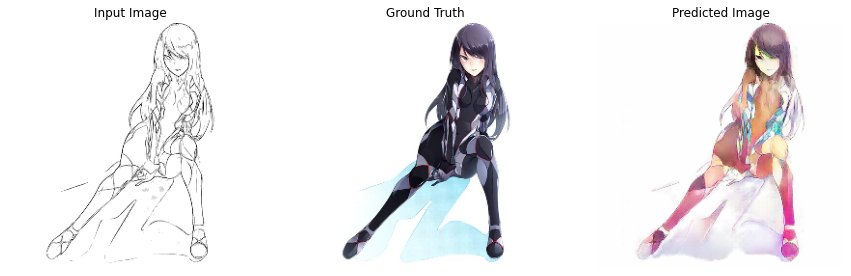

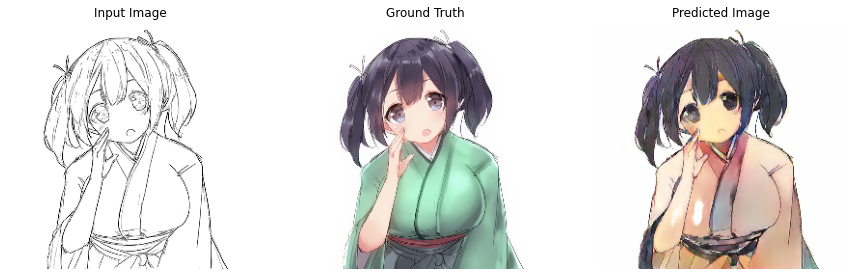

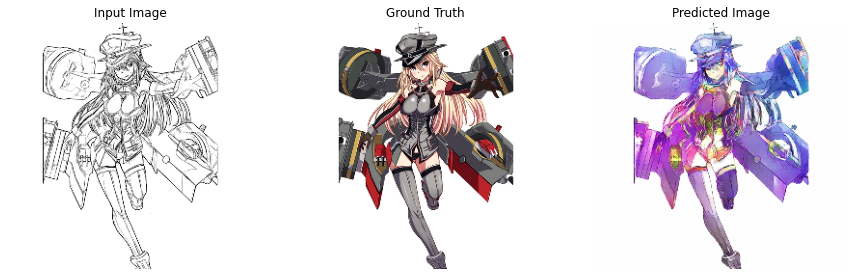

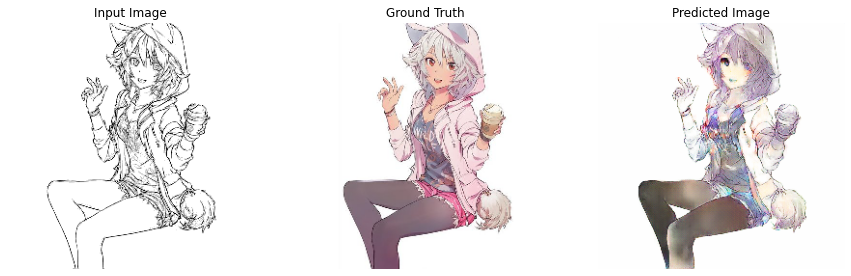

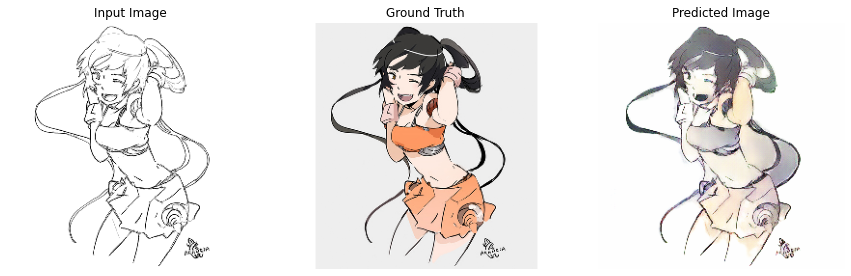

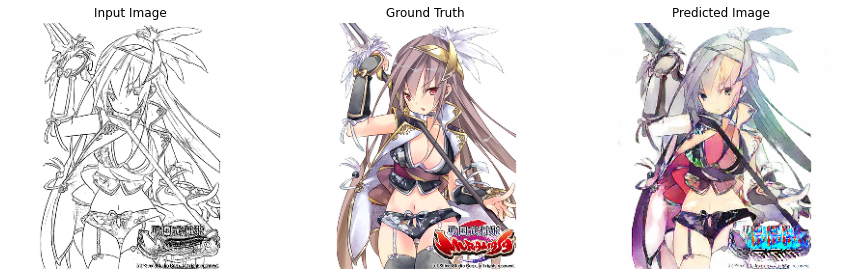

In [35]:
for example_input, example_target in testset.take(10):
    generate_images(generator, example_input, example_target)

In [38]:
generator.save('model')

INFO:tensorflow:Assets written to: model\assets


In [41]:
for example_input, example_target in testset.take(1):
    print(example_input.shape)

(256, 256, 3)
